In [1047]:
! pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1048]:
! pip install lightning-python

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1049]:
import matplotlib.pyplot as plt 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.functions import when
from pyspark import SparkContext as sc
from pyspark.sql.functions import col, split, ltrim, substring
import pyspark.sql as SQL
from pyspark.sql.functions import unix_timestamp, from_unixtime, date_format, \
        from_utc_timestamp, to_utc_timestamp, date_format, dayofmonth
import datetime
import calendar
import pandas as pd
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import *


In [1050]:
spark = SparkSession.builder.appName('Jan-01').getOrCreate()

In [1051]:
# Download and decompress data into your Jupyter environment; abreviated jan 2017 data
jan_2017 = spark.read.format("csv").load('yellow_tripdata_half.csv', header = True).cache()

In [1052]:
#need to get two dataframes to merge on, or else get cartesian product error
taxi_zone = spark.read.format("csv").load('taxi+_zone_lookup.csv', header = True)
# taxi_zone2 = spark.read.format("csv").load('taxi+_zone_lookup.csv', header = True)


In [1053]:
#taxi_zone.printSchema()

In [1054]:
#merging to get destination information
jan_2017 = jan_2017.join(taxi_zone, jan_2017.PULocationID == taxi_zone.LocationID, "left_outer"). \
                withColumnRenamed("Borough", "PUBorough").withColumnRenamed("Zone", "PUZone").withColumnRenamed("service_zone", "PUServiceZone").\
                withColumnRenamed("neighborhood", "PUneighbor").cache()

In [1055]:
# #merging to get destination information
# jan_2017 = jan_2017.join(taxi_zone2, jan_2017.DOLocationID == taxi_zone2.LocationID, "left_outer"). \
#                 withColumnRenamed("Borough", "DOBorough").withColumnRenamed("Zone", "DOZone").withColumnRenamed("service_zone", "DOServiceZone").\
#                 withColumnRenamed("neighborhood", "DOneighbor")

In [1056]:
#jan_2017 = jan_2017.drop("LocationID")

In [1057]:
#encoding if pickup is an aiport
jan_2017 = jan_2017.withColumn("AirportPU", \
                               F.when((jan_2017["PULocationID"] == '138' ) & \
                                      (jan_2017["PULocationID"] == '132'),1).otherwise(0))

In [1058]:
#jan_2017.count()

In [1059]:
#jan_2017.printSchema()

In [1060]:
#jan_2017.show(10)

In [1062]:
jan_2017 = jan_2017.where((jan_2017['PUBorough'] != 'Unknown'))

In [1063]:
#splitting date and time into different columns, casting date into date type
split_pickup_col = split(jan_2017['tpep_pickup_datetime'], ' ')
# split_dropoff_col = split(jan_2017['tpep_dropoff_datetime'], ' ')
jan_2017 = jan_2017.withColumn("PUDate", split_pickup_col.getItem(0).cast(DateType()))
jan_2017 = jan_2017.withColumn("PUTime", split_pickup_col.getItem(1))
# jan_2017 = jan_2017.withColumn("DODate", split_dropoff_col.getItem(0).cast(DateType()))
# jan_2017 = jan_2017.withColumn("DOTime", split_dropoff_col.getItem(1))

In [1064]:
#splitting time into hour and minute; will round minute to nearest 5 minutes
split_PUTime = split(jan_2017['PUTime'], ':')
jan_2017 = jan_2017.withColumn("PUHour", split_PUTime.getItem(0).cast(IntegerType()))
jan_2017 = jan_2017.withColumn("PUMinute", split_PUTime.getItem(1).cast(IntegerType()))

# split_DOTime = split(jan_2017['DOTime'], ':')
# jan_2017 = jan_2017.withColumn("DOHour", split_DOTime.getItem(0).cast(IntegerType()))
# jan_2017 = jan_2017.withColumn("DOMinute", split_DOTime.getItem(1).cast(IntegerType()))

In [ ]:
jan_2017 = jan_2017.withColumn("MorningRushHour", \
                               F.when((jan_2017["PUHour"] >= 6 ) & \
                                      (jan_2017["PUHour"] < 9),1).otherwise(0))

In [ ]:
jan_2017 = jan_2017.withColumn("EveningRushHour", \
                               F.when((jan_2017["PUHour"] >= 5 ) & \
                                      (jan_2017["PUHour"] < 9),1).otherwise(0))

In [1065]:
#rounding down mintue to closest 5 minute mark (computationally easier)
#jan_2017 = jan_2017.withColumn("DOMinute", (jan_2017.DOMinute - jan_2017.DOMinute%5))
jan_2017 = jan_2017.withColumn("PUMinute", (jan_2017.PUMinute - jan_2017.PUMinute%5))

In [1066]:
#DOW gives you 1 (Monday) - 7 (Sunday)
jan_2017 = jan_2017.withColumn("PU_DOW",  date_format(jan_2017.PUDate, 'u').cast(ShortType()))
#jan_2017 = jan_2017.withColumn("DO_DOW",  date_format(jan_2017.DODate, 'u').cast(ShortType()))

In [1067]:
#encoding if destination is a weekend
jan_2017 = jan_2017.withColumn("Weekend", \
                               F.when((jan_2017["PU_DOW"] == 7) | \
                                      (jan_2017["PU_DOW"] == 6) ),1).otherwise(0))

In [ ]:
jan_2017 = jan_2017.withColumn("WorkingHour", \
                               F.when(((jan_2017["PUHour"] >= 9 ) & \
                                      (jan_2017["PUHour"] < 5) &jan_2017["Weekend"] == 0 )   ,1).otherwise(0))

In [1068]:
#casting data types to primitives

#1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
jan_2017 = jan_2017.withColumn("VendorID", jan_2017["VendorID"].cast(ShortType()))

jan_2017 = jan_2017.withColumn("passenger_count", jan_2017["passenger_count"].cast(ShortType()))

#in miles
jan_2017 = jan_2017.withColumn("trip_distance", jan_2017["trip_distance"].cast(FloatType()))

#1= Credit card
#2= Cash
#3= No charge
#4= Dispute
#5= Unknown
#6= Voided trip
jan_2017 = jan_2017.withColumn("payment_type", jan_2017["payment_type"].cast(ShortType()))
jan_2017 = jan_2017.withColumn("fare_amount", jan_2017["fare_amount"].cast(FloatType()))

#0.50 and $1 rush hour and overnight charges.
jan_2017 = jan_2017.withColumn("extra", jan_2017["extra"].cast(FloatType()))
#.50, automatic MTA charge
jan_2017 = jan_2017.withColumn("mta_tax", jan_2017["mta_tax"].cast(FloatType()))


jan_2017 = jan_2017.withColumn("tip_amount", jan_2017["tip_amount"].cast(FloatType()))
jan_2017 = jan_2017.withColumn("tolls_amount", jan_2017["tolls_amount"].cast(FloatType()))
jan_2017 = jan_2017.withColumn("improvement_surcharge", jan_2017["improvement_surcharge"].cast(FloatType()))
jan_2017 = jan_2017.withColumn("total_amount", jan_2017["total_amount"].cast(FloatType()))


jan_2017 = jan_2017.withColumn("RateCodeID", jan_2017["RateCodeID"].cast(ShortType()))
#1= Standard rate
#2=JFK -> $52 flat fare
#3=Newark
#4=Nassau or Westchester
#5=Negotiated fare
#6=Group ride

In [1069]:
#column for looking at average dollar/mile, will used for filtering: should be around $2.5 per mile according to MTA
#use fare amount because tips can be large if generous 
jan_2017 = jan_2017.withColumn("cost_per_mile", (jan_2017["fare_amount"]/jan_2017["trip_distance"]).cast(FloatType()))
#column for looking at average miles per dollar, will be used for filtering: should be around 0.4 miles per dollar
#use fare amount because tips can be large if generous 
jan_2017 = jan_2017.withColumn("miles_per_dollar", (jan_2017["trip_distance"]/jan_2017["fare_amount"]).cast(FloatType()))

#use fare amount because tips can be large if generous 
jan_2017 = jan_2017.withColumn("missing_money", (jan_2017["total_amount"]-jan_2017["fare_amount"]-jan_2017["extra"] \
                                                 - jan_2017["mta_tax"] - jan_2017["tip_amount"] - jan_2017["tolls_amount"] \
                                                 - jan_2017["improvement_surcharge"]).cast(FloatType()))
                                                
                                    

In [1070]:
#basic fare cleaning, ensure that all values are above zero
jan_2017 = jan_2017.filter(jan_2017.tip_amount >= 0)
jan_2017 = jan_2017.filter(jan_2017.tolls_amount >= 0.0) 
jan_2017 = jan_2017.filter(jan_2017.total_amount >= 3.30)
jan_2017 = jan_2017.filter(jan_2017.extra >= 0.00)
jan_2017 = jan_2017.filter(jan_2017.cost_per_mile.isNotNull())


#minimum fare amounts according to NYC Taxi data standards
jan_2017 = jan_2017.filter((jan_2017.fare_amount >= 2.50))
jan_2017 = jan_2017.filter(jan_2017.improvement_surcharge >= 0.3)
jan_2017 = jan_2017.filter(jan_2017.mta_tax >= 0.5)

#maximum fare amount, no (logical) fares were greater than 600 although some tips might be 
#jan_2017 = jan_2017.filter((jan_2017.fare_amount < 600.0))
#all trips being filtered out of the max cost per mile going < 0.1 miles 
#there were MANY trips that had a cost per mile of 1733.3334 with the total trip distance being exactly 0.03 and the fare amount being exactly 52




#jan_2017.describe("fare_amount").show()

#jan_2017.describe("DOLocationID").show()

#jan_2017.count()
#0.646167527% of trips invalidated using basic filters of fare amounts

In [1071]:
#missing money description
#jan_2017.describe("missing_money").show()
#jan_2017.sort('missing_money', ascending=False).select(["missing_money"]).show(50)

In [1072]:
#jan_2017.sort('fare_amount', ascending=False).select(["fare_amount", "trip_distance", "cost_per_mile"]).show(50)

In [1073]:
#jan_2017.sort('trip_distance', ascending=False).select(["fare_amount", "trip_distance", "cost_per_mile"]).show(50)

In [1074]:
#jan_2017.describe("cost_per_mile").show()

#jan_2017.describe("miles_per_dollar").show()

In [1075]:
#jan_2017.describe("tip_amount").show()
#jan_2017.sort('tip_amount', ascending=False).select("tip_amount").show(50)

In [1076]:
#jan_2017.sort('cost_per_mile', ascending=False).select(["miles_per_dollar", "cost_per_mile", "trip_distance",  "total_amount",  "fare_amount", "tip_amount", "tolls_amount"]).show(50)
#upper bound of cost per mile is currently  1733.34

In [1077]:
#jan_2017.sort('cost_per_mile', ascending=True).select(["cost_per_mile", "trip_distance",  "total_amount",  "fare_amount","extra", "tip_amount", "tolls_amount", "improvement_surcharge" ]).show(50)

#lower bound of cost per mile is currently 

In [1078]:
#jan_2017.describe("total_amount").show()
#jan_2017.sort('total_amount', ascending=False).select("total_amount").show(50)

In [1079]:
#jan_2017.describe("improvement_surcharge").show()

In [1080]:
#jan_2017.describe("trip_distance").show()
#jan_2017.sort('trip_distance', ascending=False).select("trip_distance").show(50)

In [1081]:
#jan_2017.select('tpep_pickup_datetime').show(10)

In [1082]:
#jan_2017.select('PUDate').distinct().show()


In [1083]:
weather_data = spark.read.load('weather.txt', format="text")
#weather_data.show()

In [1084]:
weather_data.createOrReplaceTempView('weather_data_sdf')

#spark.sql('select * FROM weather_data_sdf').show()

In [1085]:
weather_data = spark.sql('SELECT CAST(split(value, ",")[0] as string) AS date, '\
                        'CAST(split(value, ",")[1] as string) as time, '\
                        'CAST(split(value, ",")[2] as float) as temp, '\
                        'CAST(split(value, ",")[3] as float) as windchill, '\
                        'CAST(split(value, ",")[4] as float) as dewpoint, '\
                        'CAST(split(value, ",")[5] as float) as humidity, '\
                        'CAST(split(value, ",")[6] as float) as pressure, '\
                        'CAST(split(value, ",")[7] as float) as visibility, '\
                        'CAST(split(value, ",")[8] as string) as windDir, '\
                        'CAST(split(value, ",")[9] as float) as windSpeed, '\
                        'CAST(split(value, ",")[10] as float) as gustSpeed, '\
                        'CAST(split(value, ",")[11] as float) as Precip, '\
                        'CAST(split(value, ",")[12] as string) as Events, '\
                        'CAST(split(value, ",")[13] as string) as Conditions '\
                         'FROM weather_data_sdf')

In [1086]:
#cast date to date type
weather_data = weather_data.withColumn("date", weather_data.date.cast(DateType()))

In [1087]:
def period(x):
    return split(split(x, ':')[1], " ")[1]

In [1088]:
def toHour(x):
    first_split = split(x, ':')
    retval = first_split[0].cast(IntegerType()) % 12
    return retval 

In [1089]:
weather_data = weather_data.withColumn("period", period("time"))

In [1090]:
#make hour military time
weather_data = weather_data.withColumn("hour", when(weather_data.period == 'PM', toHour("time") + 12).otherwise(toHour("time")))

In [1091]:
#fill any nulls
weather_data = weather_data.na.fill(0)

In [1092]:
#weather_data.printSchema()

In [1093]:
#make temporary views for joining
weather_data.createOrReplaceTempView('weather_data_sdf')

weather_data_pu = spark.sql('SELECT date AS PUTempdate, '\
                            'time as PUTemptime, ' \
                            'temp as PUtemp, '\
                            'windchill as PUwindchill, '\
                            'dewpoint as PUdewpoint, '\
                            'pressure as PUpressure, '\
                            'visibility as PUvisibility, '\
                            'windDir as PUwindDir, '\
                            'gustSpeed as PUgustSpeed, '\
                            'Precip as PUPrecip, '\
                            'Events as PUEvents, '\
                            'Conditions as PUConditions, '\
                            'period as PUperiod, '\
                            'hour as PUTemphour '\
                            'FROM weather_data_sdf')

# weather_data_do = spark.sql('SELECT date AS DOTempdate, '\
#                             'time as DOTemptime, ' \
#                             'temp as DOtemp, '\
#                             'windchill as DOwindchill, '\
#                             'dewpoint as DOdewpoint, '\
#                             'pressure as DOpressure, '\
#                             'visibility as DOvisibility, '\
#                             'windDir as DOwindDir, '\
#                             'gustSpeed as DOgustSpeed, '\
#                             'Precip as DOPrecip, '\
#                             'Events as DOEvents, '\
#                             'Conditions as DOConditions, '\
#                             'period as DOperiod, '\
#                             'hour as DOTemphour '\
#                             'FROM weather_data_sdf')

In [1094]:
jan_2017 = jan_2017.join(weather_data_pu, (jan_2017.PUDate == weather_data_pu.PUTempdate) & \
                         (jan_2017.PUHour == weather_data_pu.PUTemphour), "left_outer")


In [1095]:
# jan_2017 = jan_2017.join(weather_data_do, (jan_2017.DODate == weather_data_do.DOTempdate) & \
#                          (jan_2017.DOHour == weather_data_do.DOTemphour), "left_outer")

In [1096]:
jan_2017.printSchema()

root
 |-- VendorID: short (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: short (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- RateCodeID: short (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: short (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- LocationID: string (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- PUZone: string (nullable = true)
 |-- PUServiceZone: string (nullable = true)
 |-- PUneighbor: string (nullable = true)
 |-- AirportPU: integer (nullable = 

In [ ]:
jan_2017.createOrReplaceTempView('jan_2017_sdf')

In [ ]:
PUdemographics = spark.read.format("csv").load('demographics.csv', header = True).cache()
#DOdemographics = spark.read.format("csv").load('demographics.csv', header = True).cache()

In [ ]:
PUnames = PUdemographics.schema.names
i = 0
for name in PUnames:
    if (i != 0):
        PUdemographics = PUdemographics.withColumn("PU" + name, col(name).cast(FloatType())).drop(name)
  #      DOdemographics = DOdemographics.withColumn("DO" + name, col(name).cast(FloatType())).drop(name)
    else:
        PUdemographics = PUdemographics.withColumnRenamed(name, "PU" + name)
 #       DOdemographics = DOdemographics.withColumnRenamed(name, "DO" + name)

    i += 1

In [ ]:
PUdemographics.printSchema()

In [ ]:
jan_2017 = jan_2017.join(PUdemographics, jan_2017.PUneighbor == PUdemographics.PUneighborhood, "left_outer")

In [ ]:
#jan_2017 = jan_2017.join(DOdemographics, jan_2017.DOneighbor == DOdemographics.DOneighborhood, "left_outer")


In [ ]:
jan_2017.printSchema()

In [961]:
len(PUdemographics.schema.names)

163

In [ ]:
jan_2017.createOrReplaceTempView('jan_2017_cleaning').cache()


In [ ]:
spark.sql('select * FROM jan_2017_cleaning WHERE PUneighborhood is null').show()


#NA
#NV

In [1004]:
spark.sql('select PUZone, DOZone, count(*) FROM jan_2017_cleaning WHERE (PUBorough != "Manhattan") OR (DOBorough != "Manhattan")  GROUP BY 1, 2 ORDER BY COUNT(*) DESC').cache().show(50)


+--------------------+--------------------+--------+
|              PUZone|              DOZone|count(1)|
+--------------------+--------------------+--------+
|   LaGuardia Airport|Times Sq/Theatre ...|   16891|
|   LaGuardia Airport|        Midtown East|   15122|
|         JFK Airport|Times Sq/Theatre ...|   14400|
|   LaGuardia Airport|      Midtown Center|   13374|
|Times Sq/Theatre ...|   LaGuardia Airport|   12708|
|      Midtown Center|   LaGuardia Airport|    9656|
|         JFK Airport|        Clinton East|    8899|
|   LaGuardia Airport|         Murray Hill|    8836|
|   LaGuardia Airport|       Midtown North|    8594|
|Times Sq/Theatre ...|         JFK Airport|    8580|
|        Midtown East|   LaGuardia Airport|    8197|
|         JFK Airport|         JFK Airport|    7854|
|         JFK Airport|       Midtown South|    7707|
|         JFK Airport|        Midtown East|    7634|
|   LaGuardia Airport|       Midtown South|    7614|
|         JFK Airport|         Murray Hill|   

In [1005]:
spark.sql('select PUZone, DOZone, count(*) FROM jan_2017_cleaning  GROUP BY 1, 2 ORDER BY COUNT(*) ASC').cache().show(50)


+--------------------+--------------------+--------+
|              PUZone|              DOZone|count(1)|
+--------------------+--------------------+--------+
|Long Island City/...|Williamsbridge/Ol...|       1|
|           Homecrest|    Bensonhurst East|       1|
|           Hudson Sq|       Willets Point|       1|
|       Richmond Hill|          Whitestone|       1|
|       Midtown North|Springfield Garde...|       1|
|      Central Harlem|         Brownsville|       1|
|Long Island City/...|    Bensonhurst West|       1|
|                SoHo|Forest Park/Highl...|       1|
|Saint Michaels Ce...|Sutton Place/Turt...|       1|
|        Battery Park|     Windsor Terrace|       1|
|                SoHo|       South Jamaica|       1|
|Central Harlem North|           Flatlands|       1|
|          Greenpoint|    Bensonhurst West|       1|
|Schuylerville/Edg...|Williamsbridge/Ol...|       1|
|      West Concourse|           Woodhaven|       1|
|Long Island City/...|     Highbridge Park|   

In [1007]:
top_hours = spark.sql('select PUHour, count(*) FROM jan_2017_cleaning GROUP BY 1 ORDER BY COUNT(*) DESC').cache()


+------+--------+
|PUHour|count(1)|
+------+--------+
|    15| 1351726|
|    18| 1266444|
|    19| 1071803|
|    22| 1041595|
|    20| 1002252|
|    13| 1001010|
|    21|  955246|
|    17|  851846|
|    14|  762263|
|     8|  714739|
|     9|  671627|
|    23|  558074|
|    16|  552709|
|     1|  520125|
|    12|  512992|
|     7|  502573|
|    11|  496553|
|     0|  479534|
|    10|  435420|
|     2|  246371|
|     6|  153482|
|     3|  150118|
|     4|   90601|
|     5|   54061|
+------+--------+



In [1009]:
top_hours_per_week = spark.sql('select PU_DOW, PUHour, count(*) FROM jan_2017_cleaning GROUP BY 1, 2 ORDER BY COUNT(*) DESC').cache()


In [1010]:
top_hours_per_week.show()

+------+------+--------+
|PU_DOW|PUHour|count(1)|
+------+------+--------+
|     2|    15|  684553|
|     2|    18|  617034|
|     6|    21|  523849|
|     6|    22|  477850|
|     6|    17|  400818|
|     2|    19|  394568|
|     6|    20|  371725|
|     7|     1|  320146|
|     5|    15|  312762|
|     6|    19|  298736|
|     2|    14|  292779|
|     2|    13|  284013|
|     3|     8|  279217|
|     4|    13|  276082|
|     2|    11|  272556|
|     5|     7|  256831|
|     6|    18|  234768|
|     2|    20|  229574|
|     6|     9|  214466|
|     6|    13|  212075|
+------+------+--------+
only showing top 20 rows



In [1098]:
hours_per_day = spark.sql('select PUHour, count(*) FROM jan_2017_cleaning GROUP BY 1 ORDER BY count(*) DESC ').cache()
hours_per_day.show()

Py4JError: An error occurred while calling o14882.showString

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1035, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving


In [1039]:
hours_per_week.show(168)


+------+------+--------+-------+
|PU_DOW|PUHour|count(1)|DayTime|
+------+------+--------+-------+
|     1|     0|   11165|   null|
|     1|     1|    7388|   null|
|     1|     2|    4678|   null|
|     1|     3|    3565|   null|
|     1|     4|    3879|   null|
|     1|     5|    5758|   null|
|     1|     6|   12149|   null|
|     1|     7|   19942|   null|
|     1|     8|   24281|   null|
|     1|     9|   24881|   null|
|     1|    10|   23999|   null|
|     1|    11|   25224|   null|
|     1|    12|   28497|   null|
|     1|    13|   29117|   null|
|     1|    14|  162280|   null|
|     1|    15|  164357|   null|
|     1|    16|   45268|   null|
|     1|    17|   49382|   null|
|     1|    18|  179867|   null|
|     1|    19|   47252|   null|
|     1|    20|   40724|   null|
|     1|    21|   38088|   null|
|     1|    22|   33057|   null|
|     1|    23|   23264|   null|
|     2|     0|   32255|   null|
|     2|     1|   17919|   null|
|     2|     2|   11245|   null|
|     2|  

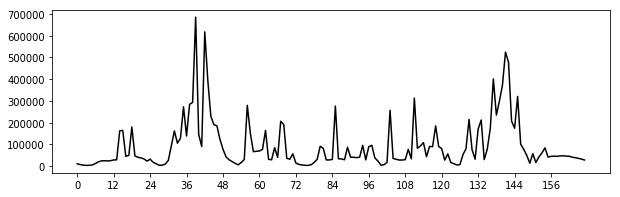

In [1045]:
import matplotlib.pyplot as plt
import numpy as np
# create some random data
y = np.array(hours_per_week.select('count(1)').collect())
x = np.arange(len(y))



# plot it
fig, ax = plt.subplots(1,1,figsize=(10,3))
plt.plot(y, color='k')
plt.xticks(np.arange(min(x), max(x)+1, 12.0))


#show it
plt.show()

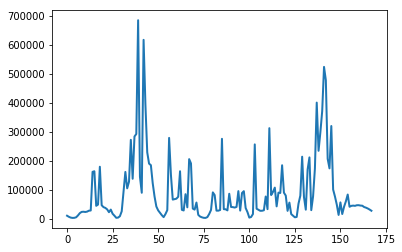

In [1044]:
plt.plot(x, y, linewidth=2.0)


In [1046]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
x = jan_2017[('')]